In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [125]:
import os
from tqdm.notebook import tqdm
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [126]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,),std=(0.5,))
                                ])

In [127]:
dataset = MNIST(root='./data',train=True,transform=transform,download=True)

In [128]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Shape:  torch.Size([1, 28, 28])
Label:  5


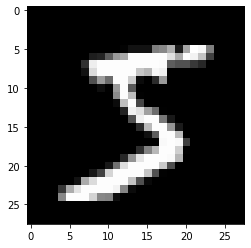

In [129]:
img,label = dataset[0]
plt.imshow(denorm(img[0]),cmap='gray')
print("Shape: ",img.shape)
print("Label: ",label)

# Dataloader and Visualising a Batch of images

In [130]:
batch_size = 100
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=3,pin_memory=True)

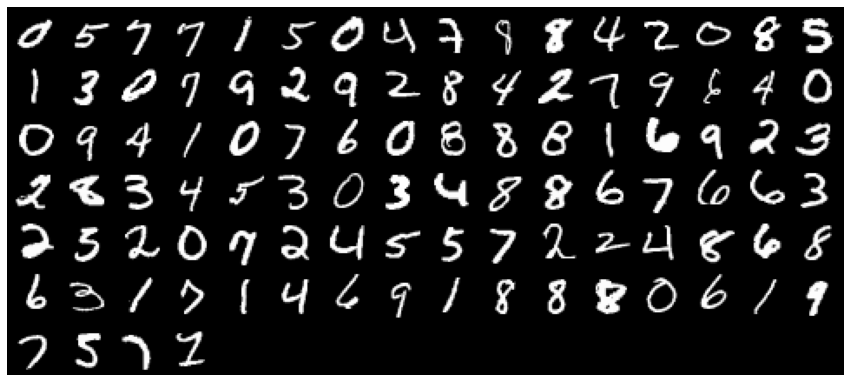

In [131]:
for images,labels in train_loader:
  plt.figure(figsize=(15,8))
  plt.imshow(make_grid(denorm(images),nrow=16).permute(1,2,0))
  plt.axis('off')
  break

# Using GPU

In [132]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_device()
device

device(type='cuda')

In [133]:
image_shape = 784
hidden_state = 256
latent_size = 64

# Discriminator Model

In [134]:
discriminator = nn.Sequential(
    nn.Linear(image_shape,hidden_state),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_state,hidden_state),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_state,1),
    nn.Sigmoid()
)

# Generator Model

In [135]:
generator = nn.Sequential(
    nn.Linear(latent_size,hidden_state),
    nn.ReLU(),
    nn.Linear(hidden_state,hidden_state),
    nn.ReLU(),
    nn.Linear(hidden_state,image_shape),
    nn.Tanh()
)

In [136]:
xb = torch.randn(2,64)
im = generator(xb)
gen_img = im.reshape(-1,28,28).detach()

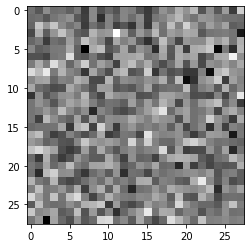

In [137]:
plt.imshow(denorm(gen_img[0]),cmap='gray')

In [138]:
discriminator = discriminator.to(device)
generator = generator.to(device)

# Training the discriminator

In [139]:
d_optimizer = torch.optim.Adam(discriminator.parameters(),lr = 0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(),lr = 0.0002)

In [140]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

def train_discriminator(real_images):

  reset_grad()

  real_labels = torch.ones(batch_size,1).to(device)
  fake_labels = torch.zeros(batch_size,1).to(device)

  real_out = discriminator(real_images)
  d_loss_real = F.binary_cross_entropy(real_out,real_labels)
  real_score = real_out

  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = generator(z)

  fake_out = discriminator(fake_images)
  d_loss_fake = F.binary_cross_entropy(fake_out,fake_labels)
  fake_score = fake_out

  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()

  return d_loss, real_score, fake_score

# Training the Generator

In [141]:
def train_generator():
  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = generator(z)
  labels = torch.ones(batch_size, 1).to(device)
  g_loss = F.binary_cross_entropy(discriminator(fake_images), labels)

  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  return g_loss,fake_images

# Generating Some new images and saving them

In [142]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [143]:
sample_vectors = torch.randn(100, latent_size).to(device)

def save_fake_images(index):
    fake_images = generator(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Training the model for some epochs

In [144]:
def fit(num_epochs):
  g_losses = []
  d_losses = []
  real_scores = []
  fake_scores = []
  
  for epoch in range(num_epochs):
    for images,lables in tqdm(train_loader):
      images = images.reshape(batch_size,-1).to(device)
      d_loss, real_score, fake_score = train_discriminator(images)
      g_loss, fake_images = train_generator()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    real_scores.append(real_score.mean().item())
    fake_scores.append(fake_score.mean().item())

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, num_epochs, g_loss.item(), d_loss.item(), real_score.mean().item(), fake_score.mean().item()))
    save_fake_images(epoch+1)

In [145]:
fit(300)


Epoch [1/300], loss_g: 5.5420, loss_d: 0.0385, real_score: 0.9865, fake_score: 0.0238
Saving fake_images-0001.png



Epoch [2/300], loss_g: 3.5432, loss_d: 0.3805, real_score: 0.9690, fake_score: 0.2690
Saving fake_images-0002.png



Epoch [3/300], loss_g: 2.7737, loss_d: 0.6984, real_score: 0.8331, fake_score: 0.2802
Saving fake_images-0003.png



Epoch [4/300], loss_g: 3.5888, loss_d: 0.2520, real_score: 0.9259, fake_score: 0.1240
Saving fake_images-0004.png



Epoch [5/300], loss_g: 3.9803, loss_d: 0.1652, real_score: 0.9473, fake_score: 0.0796
Saving fake_images-0005.png



Epoch [6/300], loss_g: 3.7731, loss_d: 0.1735, real_score: 0.9400, fake_score: 0.0534
Saving fake_images-0006.png



Epoch [7/300], loss_g: 4.8205, loss_d: 0.0723, real_score: 0.9842, fake_score: 0.0462
Saving fake_images-0007.png



Epoch [8/300], loss_g: 4.2888, loss_d: 0.0927, real_score: 0.9756, fake_score: 0.0553
Saving fake_images-0008.png



Epoch [9/300], loss_g: 6.3958, loss_d: 0.1031, real_score: 0.9737, fake_score: 0.0258
Saving fake_images-0009.png



Epoch [10/300], loss_g: 8.1468, loss_d: 0.0798, real_score: 0.9602, fake_score: 0.0096
Saving fake_images-0010.png



Epoch [11/300], loss_g: 5.0923, loss_d: 0.1646, real_score: 0.9600, fake_score: 0.0432
Saving fake_images-0011.png



Epoch [12/300], loss_g: 5.7111, loss_d: 0.2965, real_score: 0.9400, fake_score: 0.1159
Saving fake_images-0012.png



Epoch [13/300], loss_g: 6.4074, loss_d: 0.4084, real_score: 0.9933, fake_score: 0.2222
Saving fake_images-0013.png



Epoch [14/300], loss_g: 6.0219, loss_d: 0.1972, real_score: 0.9728, fake_score: 0.1069
Saving fake_images-0014.png



Epoch [15/300], loss_g: 4.6757, loss_d: 0.2531, real_score: 0.9570, fake_score: 0.0968
Saving fake_images-0015.png



Epoch [16/300], loss_g: 4.4531, loss_d: 0.2435, real_score: 0.9548, fake_score: 0.0850
Saving fake_images-0016.png



Epoch [17/300], loss_g: 4.5718, loss_d: 0.2706, real_score: 0.9108, fake_score: 0.0454
Saving fake_images-0017.png



Epoch [18/300], loss_g: 4.5520, loss_d: 0.4378, real_score: 0.8825, fake_score: 0.0422
Saving fake_images-0018.png



Epoch [19/300], loss_g: 3.8134, loss_d: 0.1373, real_score: 0.9683, fake_score: 0.0795
Saving fake_images-0019.png



Epoch [20/300], loss_g: 5.4635, loss_d: 0.1775, real_score: 0.9326, fake_score: 0.0548
Saving fake_images-0020.png



Epoch [21/300], loss_g: 4.6644, loss_d: 0.3517, real_score: 0.9356, fake_score: 0.0901
Saving fake_images-0021.png



Epoch [22/300], loss_g: 5.3686, loss_d: 0.1898, real_score: 0.9394, fake_score: 0.0384
Saving fake_images-0022.png



Epoch [23/300], loss_g: 4.0050, loss_d: 0.2367, real_score: 0.9578, fake_score: 0.0921
Saving fake_images-0023.png



Epoch [24/300], loss_g: 4.5791, loss_d: 0.3348, real_score: 0.9626, fake_score: 0.1843
Saving fake_images-0024.png



Epoch [25/300], loss_g: 4.5125, loss_d: 0.2341, real_score: 0.9306, fake_score: 0.0658
Saving fake_images-0025.png



Epoch [26/300], loss_g: 4.3602, loss_d: 0.3954, real_score: 0.9748, fake_score: 0.1879
Saving fake_images-0026.png



Epoch [27/300], loss_g: 5.1179, loss_d: 0.1807, real_score: 0.9036, fake_score: 0.0173
Saving fake_images-0027.png



Epoch [28/300], loss_g: 3.8697, loss_d: 0.2787, real_score: 0.9179, fake_score: 0.1091
Saving fake_images-0028.png



Epoch [29/300], loss_g: 3.6431, loss_d: 0.4460, real_score: 0.8856, fake_score: 0.1328
Saving fake_images-0029.png



Epoch [30/300], loss_g: 5.1928, loss_d: 0.1847, real_score: 0.9551, fake_score: 0.0783
Saving fake_images-0030.png



Epoch [31/300], loss_g: 4.3134, loss_d: 0.2491, real_score: 0.9106, fake_score: 0.0619
Saving fake_images-0031.png



Epoch [32/300], loss_g: 4.3605, loss_d: 0.4878, real_score: 0.9268, fake_score: 0.1817
Saving fake_images-0032.png



Epoch [33/300], loss_g: 3.1578, loss_d: 0.3567, real_score: 0.9071, fake_score: 0.0780
Saving fake_images-0033.png



Epoch [34/300], loss_g: 3.8391, loss_d: 0.2932, real_score: 0.9384, fake_score: 0.1434
Saving fake_images-0034.png



Epoch [35/300], loss_g: 4.3681, loss_d: 0.3205, real_score: 0.8943, fake_score: 0.0876
Saving fake_images-0035.png



Epoch [36/300], loss_g: 3.2385, loss_d: 0.3661, real_score: 0.9078, fake_score: 0.1045
Saving fake_images-0036.png



Epoch [37/300], loss_g: 3.9607, loss_d: 0.5286, real_score: 0.9124, fake_score: 0.2388
Saving fake_images-0037.png



Epoch [38/300], loss_g: 2.3248, loss_d: 0.6376, real_score: 0.8348, fake_score: 0.2268
Saving fake_images-0038.png



Epoch [39/300], loss_g: 2.5608, loss_d: 0.4586, real_score: 0.8709, fake_score: 0.1582
Saving fake_images-0039.png



Epoch [40/300], loss_g: 2.4692, loss_d: 0.4911, real_score: 0.8325, fake_score: 0.1504
Saving fake_images-0040.png



Epoch [41/300], loss_g: 2.8547, loss_d: 0.4949, real_score: 0.8501, fake_score: 0.1650
Saving fake_images-0041.png



Epoch [42/300], loss_g: 3.8847, loss_d: 0.5401, real_score: 0.7799, fake_score: 0.0617
Saving fake_images-0042.png



Epoch [43/300], loss_g: 3.6586, loss_d: 0.5588, real_score: 0.8185, fake_score: 0.1249
Saving fake_images-0043.png



Epoch [44/300], loss_g: 4.2033, loss_d: 0.4376, real_score: 0.9053, fake_score: 0.1812
Saving fake_images-0044.png



Epoch [45/300], loss_g: 2.2163, loss_d: 0.5626, real_score: 0.7802, fake_score: 0.0970
Saving fake_images-0045.png



Epoch [46/300], loss_g: 2.7373, loss_d: 0.5262, real_score: 0.8563, fake_score: 0.1965
Saving fake_images-0046.png



Epoch [47/300], loss_g: 2.0770, loss_d: 0.8542, real_score: 0.7881, fake_score: 0.2918
Saving fake_images-0047.png



Epoch [48/300], loss_g: 2.4173, loss_d: 0.7290, real_score: 0.8591, fake_score: 0.3049
Saving fake_images-0048.png



Epoch [49/300], loss_g: 2.5520, loss_d: 0.4874, real_score: 0.8672, fake_score: 0.1974
Saving fake_images-0049.png



Epoch [50/300], loss_g: 2.5420, loss_d: 0.7615, real_score: 0.8099, fake_score: 0.2940
Saving fake_images-0050.png



Epoch [51/300], loss_g: 2.9318, loss_d: 0.5246, real_score: 0.7955, fake_score: 0.1348
Saving fake_images-0051.png



Epoch [52/300], loss_g: 3.0457, loss_d: 0.3690, real_score: 0.8992, fake_score: 0.1649
Saving fake_images-0052.png



Epoch [53/300], loss_g: 3.0495, loss_d: 0.3911, real_score: 0.8452, fake_score: 0.1168
Saving fake_images-0053.png



Epoch [54/300], loss_g: 3.3636, loss_d: 0.5223, real_score: 0.8253, fake_score: 0.1493
Saving fake_images-0054.png



Epoch [55/300], loss_g: 2.8427, loss_d: 0.5396, real_score: 0.8629, fake_score: 0.2069
Saving fake_images-0055.png



Epoch [56/300], loss_g: 2.6108, loss_d: 0.6229, real_score: 0.7565, fake_score: 0.1098
Saving fake_images-0056.png



Epoch [57/300], loss_g: 2.9779, loss_d: 0.5481, real_score: 0.8627, fake_score: 0.2215
Saving fake_images-0057.png



Epoch [58/300], loss_g: 3.2123, loss_d: 0.3878, real_score: 0.8527, fake_score: 0.1216
Saving fake_images-0058.png



Epoch [59/300], loss_g: 2.1334, loss_d: 0.5358, real_score: 0.8412, fake_score: 0.2355
Saving fake_images-0059.png



Epoch [60/300], loss_g: 2.3252, loss_d: 0.7037, real_score: 0.8034, fake_score: 0.2578
Saving fake_images-0060.png



Epoch [61/300], loss_g: 2.3123, loss_d: 0.6278, real_score: 0.7744, fake_score: 0.1634
Saving fake_images-0061.png



Epoch [62/300], loss_g: 2.6832, loss_d: 0.6525, real_score: 0.7624, fake_score: 0.1685
Saving fake_images-0062.png



Epoch [63/300], loss_g: 2.9510, loss_d: 0.5741, real_score: 0.8903, fake_score: 0.2822
Saving fake_images-0063.png



Epoch [64/300], loss_g: 2.2988, loss_d: 0.5991, real_score: 0.8787, fake_score: 0.2904
Saving fake_images-0064.png



Epoch [65/300], loss_g: 2.9642, loss_d: 0.6313, real_score: 0.8123, fake_score: 0.2343
Saving fake_images-0065.png



Epoch [66/300], loss_g: 2.2071, loss_d: 0.7122, real_score: 0.7509, fake_score: 0.1907
Saving fake_images-0066.png



Epoch [67/300], loss_g: 3.4275, loss_d: 0.7281, real_score: 0.7164, fake_score: 0.1702
Saving fake_images-0067.png



Epoch [68/300], loss_g: 2.0144, loss_d: 0.6193, real_score: 0.8249, fake_score: 0.2564
Saving fake_images-0068.png



Epoch [69/300], loss_g: 2.3803, loss_d: 0.7682, real_score: 0.8597, fake_score: 0.3223
Saving fake_images-0069.png



Epoch [70/300], loss_g: 1.8604, loss_d: 0.9549, real_score: 0.6773, fake_score: 0.2014
Saving fake_images-0070.png



Epoch [71/300], loss_g: 2.8912, loss_d: 0.4684, real_score: 0.7884, fake_score: 0.1270
Saving fake_images-0071.png



Epoch [72/300], loss_g: 2.0071, loss_d: 0.7962, real_score: 0.7432, fake_score: 0.2157
Saving fake_images-0072.png



Epoch [73/300], loss_g: 2.0541, loss_d: 0.7255, real_score: 0.8069, fake_score: 0.3025
Saving fake_images-0073.png



Epoch [74/300], loss_g: 2.9666, loss_d: 0.6906, real_score: 0.7647, fake_score: 0.2097
Saving fake_images-0074.png



Epoch [75/300], loss_g: 1.8000, loss_d: 0.7575, real_score: 0.7327, fake_score: 0.2203
Saving fake_images-0075.png



Epoch [76/300], loss_g: 2.4793, loss_d: 0.7536, real_score: 0.6949, fake_score: 0.1542
Saving fake_images-0076.png



Epoch [77/300], loss_g: 2.2726, loss_d: 0.7233, real_score: 0.8027, fake_score: 0.2693
Saving fake_images-0077.png



Epoch [78/300], loss_g: 2.5829, loss_d: 0.5707, real_score: 0.7699, fake_score: 0.1501
Saving fake_images-0078.png



Epoch [79/300], loss_g: 1.4865, loss_d: 0.9313, real_score: 0.6842, fake_score: 0.2306
Saving fake_images-0079.png



Epoch [80/300], loss_g: 2.1515, loss_d: 0.7569, real_score: 0.7608, fake_score: 0.2123
Saving fake_images-0080.png



Epoch [81/300], loss_g: 2.4721, loss_d: 0.5576, real_score: 0.7754, fake_score: 0.1827
Saving fake_images-0081.png



Epoch [82/300], loss_g: 1.5826, loss_d: 0.7439, real_score: 0.7760, fake_score: 0.2968
Saving fake_images-0082.png



Epoch [83/300], loss_g: 2.1247, loss_d: 0.6836, real_score: 0.7893, fake_score: 0.2535
Saving fake_images-0083.png



Epoch [84/300], loss_g: 2.0356, loss_d: 0.8555, real_score: 0.7346, fake_score: 0.2635
Saving fake_images-0084.png



Epoch [85/300], loss_g: 2.1090, loss_d: 0.8906, real_score: 0.7621, fake_score: 0.3388
Saving fake_images-0085.png



Epoch [86/300], loss_g: 2.1546, loss_d: 0.8157, real_score: 0.7926, fake_score: 0.3289
Saving fake_images-0086.png



Epoch [87/300], loss_g: 1.7666, loss_d: 0.8918, real_score: 0.6997, fake_score: 0.2452
Saving fake_images-0087.png



Epoch [88/300], loss_g: 1.3263, loss_d: 0.7807, real_score: 0.7481, fake_score: 0.2669
Saving fake_images-0088.png



Epoch [89/300], loss_g: 1.6783, loss_d: 0.8871, real_score: 0.7976, fake_score: 0.3680
Saving fake_images-0089.png



Epoch [90/300], loss_g: 2.0363, loss_d: 0.7280, real_score: 0.7380, fake_score: 0.1943
Saving fake_images-0090.png



Epoch [91/300], loss_g: 2.0439, loss_d: 0.8727, real_score: 0.6340, fake_score: 0.1671
Saving fake_images-0091.png



Epoch [92/300], loss_g: 2.2527, loss_d: 0.5689, real_score: 0.7907, fake_score: 0.2067
Saving fake_images-0092.png



Epoch [93/300], loss_g: 1.8478, loss_d: 0.8301, real_score: 0.7226, fake_score: 0.2615
Saving fake_images-0093.png



Epoch [94/300], loss_g: 1.8940, loss_d: 0.6750, real_score: 0.8164, fake_score: 0.2758
Saving fake_images-0094.png



Epoch [95/300], loss_g: 1.5541, loss_d: 0.8509, real_score: 0.7205, fake_score: 0.2664
Saving fake_images-0095.png



Epoch [96/300], loss_g: 2.2906, loss_d: 0.7035, real_score: 0.7534, fake_score: 0.2251
Saving fake_images-0096.png



Epoch [97/300], loss_g: 2.2636, loss_d: 0.7372, real_score: 0.7824, fake_score: 0.2868
Saving fake_images-0097.png



Epoch [98/300], loss_g: 1.7356, loss_d: 0.8525, real_score: 0.7388, fake_score: 0.2993
Saving fake_images-0098.png



Epoch [99/300], loss_g: 1.7464, loss_d: 0.8654, real_score: 0.7306, fake_score: 0.3111
Saving fake_images-0099.png



Epoch [100/300], loss_g: 1.9521, loss_d: 0.7953, real_score: 0.6905, fake_score: 0.2014
Saving fake_images-0100.png



Epoch [101/300], loss_g: 2.3021, loss_d: 0.7580, real_score: 0.7296, fake_score: 0.2437
Saving fake_images-0101.png



Epoch [102/300], loss_g: 1.9596, loss_d: 0.7726, real_score: 0.7683, fake_score: 0.2738
Saving fake_images-0102.png



Epoch [103/300], loss_g: 2.3489, loss_d: 0.8002, real_score: 0.6983, fake_score: 0.2158
Saving fake_images-0103.png



Epoch [104/300], loss_g: 1.7696, loss_d: 0.9408, real_score: 0.6672, fake_score: 0.2586
Saving fake_images-0104.png



Epoch [105/300], loss_g: 1.9535, loss_d: 0.7508, real_score: 0.7250, fake_score: 0.2550
Saving fake_images-0105.png



Epoch [106/300], loss_g: 2.0585, loss_d: 0.7055, real_score: 0.7419, fake_score: 0.2433
Saving fake_images-0106.png



Epoch [107/300], loss_g: 2.0561, loss_d: 0.7241, real_score: 0.6823, fake_score: 0.1796
Saving fake_images-0107.png



Epoch [108/300], loss_g: 1.9423, loss_d: 0.8971, real_score: 0.6807, fake_score: 0.2462
Saving fake_images-0108.png



Epoch [109/300], loss_g: 1.5633, loss_d: 0.7715, real_score: 0.7704, fake_score: 0.2896
Saving fake_images-0109.png



Epoch [110/300], loss_g: 1.9103, loss_d: 0.9305, real_score: 0.7424, fake_score: 0.3258
Saving fake_images-0110.png



Epoch [111/300], loss_g: 1.6181, loss_d: 0.8062, real_score: 0.7637, fake_score: 0.3125
Saving fake_images-0111.png



Epoch [112/300], loss_g: 1.5031, loss_d: 0.8182, real_score: 0.7786, fake_score: 0.3316
Saving fake_images-0112.png



Epoch [113/300], loss_g: 1.9210, loss_d: 0.7733, real_score: 0.7048, fake_score: 0.1826
Saving fake_images-0113.png



Epoch [114/300], loss_g: 1.9286, loss_d: 0.8222, real_score: 0.7133, fake_score: 0.2490
Saving fake_images-0114.png



Epoch [115/300], loss_g: 1.7350, loss_d: 0.8412, real_score: 0.6831, fake_score: 0.2481
Saving fake_images-0115.png



Epoch [116/300], loss_g: 2.4198, loss_d: 0.6978, real_score: 0.7111, fake_score: 0.1935
Saving fake_images-0116.png



Epoch [117/300], loss_g: 1.7218, loss_d: 0.7051, real_score: 0.7808, fake_score: 0.2750
Saving fake_images-0117.png



Epoch [118/300], loss_g: 1.1933, loss_d: 1.1187, real_score: 0.6672, fake_score: 0.3544
Saving fake_images-0118.png



Epoch [119/300], loss_g: 1.4564, loss_d: 0.9983, real_score: 0.7499, fake_score: 0.3456
Saving fake_images-0119.png



Epoch [120/300], loss_g: 1.5514, loss_d: 0.9247, real_score: 0.7717, fake_score: 0.3620
Saving fake_images-0120.png



Epoch [121/300], loss_g: 1.4892, loss_d: 0.8646, real_score: 0.7385, fake_score: 0.3081
Saving fake_images-0121.png



Epoch [122/300], loss_g: 1.6467, loss_d: 1.1063, real_score: 0.7169, fake_score: 0.3522
Saving fake_images-0122.png



Epoch [123/300], loss_g: 1.7318, loss_d: 0.7213, real_score: 0.7537, fake_score: 0.2248
Saving fake_images-0123.png



Epoch [124/300], loss_g: 1.5945, loss_d: 0.9401, real_score: 0.6420, fake_score: 0.2332
Saving fake_images-0124.png



Epoch [125/300], loss_g: 1.6926, loss_d: 1.0404, real_score: 0.6557, fake_score: 0.2786
Saving fake_images-0125.png



Epoch [126/300], loss_g: 1.7555, loss_d: 0.6746, real_score: 0.7504, fake_score: 0.2285
Saving fake_images-0126.png



Epoch [127/300], loss_g: 1.5335, loss_d: 0.8669, real_score: 0.7210, fake_score: 0.2696
Saving fake_images-0127.png



Epoch [128/300], loss_g: 1.6396, loss_d: 0.8682, real_score: 0.7602, fake_score: 0.3358
Saving fake_images-0128.png



Epoch [129/300], loss_g: 1.4609, loss_d: 0.9701, real_score: 0.7034, fake_score: 0.3035
Saving fake_images-0129.png



Epoch [130/300], loss_g: 1.7994, loss_d: 0.7572, real_score: 0.7151, fake_score: 0.2466
Saving fake_images-0130.png



Epoch [131/300], loss_g: 2.1861, loss_d: 0.6741, real_score: 0.7905, fake_score: 0.2705
Saving fake_images-0131.png



Epoch [132/300], loss_g: 1.8955, loss_d: 0.7730, real_score: 0.7251, fake_score: 0.2549
Saving fake_images-0132.png



Epoch [133/300], loss_g: 2.2337, loss_d: 0.9215, real_score: 0.7262, fake_score: 0.2923
Saving fake_images-0133.png



Epoch [134/300], loss_g: 1.9836, loss_d: 1.0602, real_score: 0.5626, fake_score: 0.2035
Saving fake_images-0134.png



Epoch [135/300], loss_g: 1.2806, loss_d: 0.8513, real_score: 0.7925, fake_score: 0.3788
Saving fake_images-0135.png



Epoch [136/300], loss_g: 1.4580, loss_d: 0.8978, real_score: 0.7248, fake_score: 0.3120
Saving fake_images-0136.png



Epoch [137/300], loss_g: 1.1591, loss_d: 0.9204, real_score: 0.6733, fake_score: 0.2813
Saving fake_images-0137.png



Epoch [138/300], loss_g: 1.6375, loss_d: 1.0372, real_score: 0.6861, fake_score: 0.3015
Saving fake_images-0138.png



Epoch [139/300], loss_g: 1.2214, loss_d: 0.8713, real_score: 0.7168, fake_score: 0.3022
Saving fake_images-0139.png



Epoch [140/300], loss_g: 1.3860, loss_d: 0.9709, real_score: 0.6925, fake_score: 0.3506
Saving fake_images-0140.png



Epoch [141/300], loss_g: 1.8920, loss_d: 1.0698, real_score: 0.5823, fake_score: 0.2388
Saving fake_images-0141.png



Epoch [142/300], loss_g: 1.6704, loss_d: 0.9024, real_score: 0.7120, fake_score: 0.2922
Saving fake_images-0142.png



Epoch [143/300], loss_g: 1.5298, loss_d: 0.9530, real_score: 0.6437, fake_score: 0.2678
Saving fake_images-0143.png



Epoch [144/300], loss_g: 1.6758, loss_d: 0.9065, real_score: 0.7698, fake_score: 0.3658
Saving fake_images-0144.png



Epoch [145/300], loss_g: 1.9226, loss_d: 0.8418, real_score: 0.6966, fake_score: 0.2833
Saving fake_images-0145.png



Epoch [146/300], loss_g: 1.7820, loss_d: 1.0104, real_score: 0.6460, fake_score: 0.3078
Saving fake_images-0146.png



Epoch [147/300], loss_g: 1.3621, loss_d: 0.9133, real_score: 0.7362, fake_score: 0.3589
Saving fake_images-0147.png



Epoch [148/300], loss_g: 1.7054, loss_d: 0.8732, real_score: 0.7072, fake_score: 0.2949
Saving fake_images-0148.png



Epoch [149/300], loss_g: 1.4251, loss_d: 0.9947, real_score: 0.6946, fake_score: 0.3407
Saving fake_images-0149.png



Epoch [150/300], loss_g: 1.5950, loss_d: 0.7772, real_score: 0.7033, fake_score: 0.2416
Saving fake_images-0150.png



Epoch [151/300], loss_g: 1.8227, loss_d: 0.9410, real_score: 0.6183, fake_score: 0.2398
Saving fake_images-0151.png



Epoch [152/300], loss_g: 1.4714, loss_d: 0.8816, real_score: 0.7230, fake_score: 0.3054
Saving fake_images-0152.png



Epoch [153/300], loss_g: 1.4802, loss_d: 0.8228, real_score: 0.7076, fake_score: 0.2691
Saving fake_images-0153.png



Epoch [154/300], loss_g: 1.6053, loss_d: 0.8578, real_score: 0.6706, fake_score: 0.2666
Saving fake_images-0154.png



Epoch [155/300], loss_g: 1.5400, loss_d: 0.8938, real_score: 0.7040, fake_score: 0.2871
Saving fake_images-0155.png



Epoch [156/300], loss_g: 1.4393, loss_d: 0.9167, real_score: 0.6597, fake_score: 0.2778
Saving fake_images-0156.png



Epoch [157/300], loss_g: 1.9368, loss_d: 0.9028, real_score: 0.7392, fake_score: 0.3345
Saving fake_images-0157.png



Epoch [158/300], loss_g: 1.4725, loss_d: 1.0589, real_score: 0.7009, fake_score: 0.3391
Saving fake_images-0158.png



Epoch [159/300], loss_g: 1.8875, loss_d: 0.9730, real_score: 0.7415, fake_score: 0.3754
Saving fake_images-0159.png



Epoch [160/300], loss_g: 1.8252, loss_d: 0.9996, real_score: 0.6420, fake_score: 0.3083
Saving fake_images-0160.png



Epoch [161/300], loss_g: 1.8038, loss_d: 0.7891, real_score: 0.7618, fake_score: 0.2816
Saving fake_images-0161.png



Epoch [162/300], loss_g: 1.8465, loss_d: 1.0668, real_score: 0.6226, fake_score: 0.2867
Saving fake_images-0162.png



Epoch [163/300], loss_g: 1.6784, loss_d: 0.7598, real_score: 0.7361, fake_score: 0.2645
Saving fake_images-0163.png



Epoch [164/300], loss_g: 1.4401, loss_d: 1.0203, real_score: 0.7246, fake_score: 0.3899
Saving fake_images-0164.png



Epoch [165/300], loss_g: 1.7646, loss_d: 0.8313, real_score: 0.7896, fake_score: 0.3478
Saving fake_images-0165.png



Epoch [166/300], loss_g: 2.2943, loss_d: 0.7753, real_score: 0.7301, fake_score: 0.2504
Saving fake_images-0166.png



Epoch [167/300], loss_g: 1.4816, loss_d: 0.9220, real_score: 0.6755, fake_score: 0.2854
Saving fake_images-0167.png



Epoch [168/300], loss_g: 1.6595, loss_d: 0.8418, real_score: 0.7329, fake_score: 0.3101
Saving fake_images-0168.png



Epoch [169/300], loss_g: 1.6392, loss_d: 0.8908, real_score: 0.6543, fake_score: 0.2085
Saving fake_images-0169.png



Epoch [170/300], loss_g: 1.7128, loss_d: 0.8315, real_score: 0.7108, fake_score: 0.2872
Saving fake_images-0170.png



Epoch [171/300], loss_g: 1.9004, loss_d: 0.8279, real_score: 0.6655, fake_score: 0.2384
Saving fake_images-0171.png



Epoch [172/300], loss_g: 1.0974, loss_d: 1.0058, real_score: 0.7105, fake_score: 0.3885
Saving fake_images-0172.png



Epoch [173/300], loss_g: 1.5701, loss_d: 0.8541, real_score: 0.7035, fake_score: 0.3007
Saving fake_images-0173.png



Epoch [174/300], loss_g: 1.7195, loss_d: 0.8972, real_score: 0.6656, fake_score: 0.2727
Saving fake_images-0174.png



Epoch [175/300], loss_g: 1.5765, loss_d: 0.9315, real_score: 0.6575, fake_score: 0.2746
Saving fake_images-0175.png



Epoch [176/300], loss_g: 1.0955, loss_d: 0.9481, real_score: 0.7073, fake_score: 0.3482
Saving fake_images-0176.png



Epoch [177/300], loss_g: 1.5694, loss_d: 0.8646, real_score: 0.7685, fake_score: 0.3612
Saving fake_images-0177.png



Epoch [178/300], loss_g: 1.3905, loss_d: 1.0200, real_score: 0.6521, fake_score: 0.3110
Saving fake_images-0178.png



Epoch [179/300], loss_g: 1.5785, loss_d: 0.8312, real_score: 0.7072, fake_score: 0.2821
Saving fake_images-0179.png



Epoch [180/300], loss_g: 1.7578, loss_d: 1.0573, real_score: 0.6532, fake_score: 0.3204
Saving fake_images-0180.png



Epoch [181/300], loss_g: 1.3974, loss_d: 1.1116, real_score: 0.6347, fake_score: 0.3211
Saving fake_images-0181.png



Epoch [182/300], loss_g: 1.9182, loss_d: 1.1156, real_score: 0.6533, fake_score: 0.3185
Saving fake_images-0182.png



Epoch [183/300], loss_g: 1.6311, loss_d: 0.9123, real_score: 0.7382, fake_score: 0.3377
Saving fake_images-0183.png



Epoch [184/300], loss_g: 1.5048, loss_d: 0.9113, real_score: 0.7283, fake_score: 0.3248
Saving fake_images-0184.png



Epoch [185/300], loss_g: 1.4960, loss_d: 0.9351, real_score: 0.6725, fake_score: 0.2971
Saving fake_images-0185.png



Epoch [186/300], loss_g: 1.4376, loss_d: 0.8723, real_score: 0.6451, fake_score: 0.2577
Saving fake_images-0186.png



Epoch [187/300], loss_g: 1.5080, loss_d: 0.9458, real_score: 0.7031, fake_score: 0.3093
Saving fake_images-0187.png



Epoch [188/300], loss_g: 1.7370, loss_d: 0.9109, real_score: 0.7768, fake_score: 0.3803
Saving fake_images-0188.png



Epoch [189/300], loss_g: 1.4357, loss_d: 0.9417, real_score: 0.7461, fake_score: 0.3677
Saving fake_images-0189.png



Epoch [190/300], loss_g: 1.7282, loss_d: 0.8062, real_score: 0.7126, fake_score: 0.2705
Saving fake_images-0190.png



Epoch [191/300], loss_g: 1.2845, loss_d: 0.8419, real_score: 0.7420, fake_score: 0.3038
Saving fake_images-0191.png



Epoch [192/300], loss_g: 1.2789, loss_d: 1.0165, real_score: 0.6471, fake_score: 0.3069
Saving fake_images-0192.png



Epoch [193/300], loss_g: 1.3204, loss_d: 0.8869, real_score: 0.7227, fake_score: 0.3098
Saving fake_images-0193.png



Epoch [194/300], loss_g: 1.3513, loss_d: 0.9032, real_score: 0.7084, fake_score: 0.3168
Saving fake_images-0194.png



Epoch [195/300], loss_g: 1.7437, loss_d: 1.0463, real_score: 0.6906, fake_score: 0.3799
Saving fake_images-0195.png



Epoch [196/300], loss_g: 1.7364, loss_d: 0.9812, real_score: 0.6054, fake_score: 0.2462
Saving fake_images-0196.png



Epoch [197/300], loss_g: 1.0986, loss_d: 1.2464, real_score: 0.5482, fake_score: 0.3323
Saving fake_images-0197.png



Epoch [198/300], loss_g: 1.8852, loss_d: 0.8158, real_score: 0.7116, fake_score: 0.2828
Saving fake_images-0198.png



Epoch [199/300], loss_g: 1.7106, loss_d: 0.7452, real_score: 0.7054, fake_score: 0.2379
Saving fake_images-0199.png



Epoch [200/300], loss_g: 1.5376, loss_d: 0.8021, real_score: 0.7404, fake_score: 0.2921
Saving fake_images-0200.png



Epoch [201/300], loss_g: 1.7909, loss_d: 0.8325, real_score: 0.7314, fake_score: 0.3101
Saving fake_images-0201.png



Epoch [202/300], loss_g: 1.3006, loss_d: 1.0700, real_score: 0.7607, fake_score: 0.4513
Saving fake_images-0202.png



Epoch [203/300], loss_g: 1.5289, loss_d: 0.9494, real_score: 0.6509, fake_score: 0.2892
Saving fake_images-0203.png



Epoch [204/300], loss_g: 1.3853, loss_d: 0.9978, real_score: 0.7314, fake_score: 0.3882
Saving fake_images-0204.png



Epoch [205/300], loss_g: 1.4780, loss_d: 1.0673, real_score: 0.6219, fake_score: 0.2799
Saving fake_images-0205.png



Epoch [206/300], loss_g: 1.4880, loss_d: 0.8402, real_score: 0.6576, fake_score: 0.2305
Saving fake_images-0206.png



Epoch [207/300], loss_g: 1.5871, loss_d: 0.8416, real_score: 0.6858, fake_score: 0.2804
Saving fake_images-0207.png



Epoch [208/300], loss_g: 1.3010, loss_d: 1.0353, real_score: 0.6544, fake_score: 0.3368
Saving fake_images-0208.png



Epoch [209/300], loss_g: 1.3690, loss_d: 1.0350, real_score: 0.6697, fake_score: 0.3166
Saving fake_images-0209.png



Epoch [210/300], loss_g: 1.4850, loss_d: 0.9483, real_score: 0.6291, fake_score: 0.2594
Saving fake_images-0210.png



Epoch [211/300], loss_g: 1.4373, loss_d: 0.8736, real_score: 0.7054, fake_score: 0.2952
Saving fake_images-0211.png



Epoch [212/300], loss_g: 1.2948, loss_d: 0.9436, real_score: 0.7146, fake_score: 0.3504
Saving fake_images-0212.png



Epoch [213/300], loss_g: 1.2045, loss_d: 0.9610, real_score: 0.7129, fake_score: 0.3466
Saving fake_images-0213.png



Epoch [214/300], loss_g: 1.3224, loss_d: 1.1202, real_score: 0.7428, fake_score: 0.4386
Saving fake_images-0214.png



Epoch [215/300], loss_g: 1.1643, loss_d: 0.9590, real_score: 0.7045, fake_score: 0.3425
Saving fake_images-0215.png



Epoch [216/300], loss_g: 2.1449, loss_d: 0.9898, real_score: 0.6116, fake_score: 0.2354
Saving fake_images-0216.png



Epoch [217/300], loss_g: 1.6579, loss_d: 0.9063, real_score: 0.7376, fake_score: 0.3428
Saving fake_images-0217.png



Epoch [218/300], loss_g: 1.5790, loss_d: 0.9541, real_score: 0.7550, fake_score: 0.3713
Saving fake_images-0218.png



Epoch [219/300], loss_g: 1.7513, loss_d: 0.8895, real_score: 0.6802, fake_score: 0.2800
Saving fake_images-0219.png



Epoch [220/300], loss_g: 1.7073, loss_d: 0.8809, real_score: 0.6306, fake_score: 0.2333
Saving fake_images-0220.png



Epoch [221/300], loss_g: 1.3298, loss_d: 1.0483, real_score: 0.6875, fake_score: 0.3314
Saving fake_images-0221.png



Epoch [222/300], loss_g: 1.3343, loss_d: 1.0139, real_score: 0.7181, fake_score: 0.3774
Saving fake_images-0222.png



Epoch [223/300], loss_g: 1.8395, loss_d: 0.9092, real_score: 0.6608, fake_score: 0.2869
Saving fake_images-0223.png



Epoch [224/300], loss_g: 1.4159, loss_d: 0.9680, real_score: 0.6610, fake_score: 0.2886
Saving fake_images-0224.png



Epoch [225/300], loss_g: 1.6222, loss_d: 0.9149, real_score: 0.7411, fake_score: 0.3364
Saving fake_images-0225.png



Epoch [226/300], loss_g: 1.6283, loss_d: 1.0240, real_score: 0.6166, fake_score: 0.2943
Saving fake_images-0226.png



Epoch [227/300], loss_g: 1.7703, loss_d: 0.8286, real_score: 0.7150, fake_score: 0.2880
Saving fake_images-0227.png



Epoch [228/300], loss_g: 1.4032, loss_d: 0.8320, real_score: 0.7349, fake_score: 0.3061
Saving fake_images-0228.png



Epoch [229/300], loss_g: 1.2635, loss_d: 0.9531, real_score: 0.7341, fake_score: 0.3886
Saving fake_images-0229.png



Epoch [230/300], loss_g: 1.7654, loss_d: 1.1020, real_score: 0.6281, fake_score: 0.3281
Saving fake_images-0230.png



Epoch [231/300], loss_g: 1.4745, loss_d: 0.9773, real_score: 0.6837, fake_score: 0.3455
Saving fake_images-0231.png



Epoch [232/300], loss_g: 1.4958, loss_d: 0.9285, real_score: 0.7665, fake_score: 0.4045
Saving fake_images-0232.png



Epoch [233/300], loss_g: 1.3176, loss_d: 1.0898, real_score: 0.5980, fake_score: 0.3192
Saving fake_images-0233.png



Epoch [234/300], loss_g: 1.4462, loss_d: 1.0051, real_score: 0.7203, fake_score: 0.4021
Saving fake_images-0234.png



Epoch [235/300], loss_g: 1.4703, loss_d: 1.0721, real_score: 0.7459, fake_score: 0.4269
Saving fake_images-0235.png



Epoch [236/300], loss_g: 1.2309, loss_d: 0.9112, real_score: 0.6975, fake_score: 0.2944
Saving fake_images-0236.png



Epoch [237/300], loss_g: 1.6179, loss_d: 1.0944, real_score: 0.5905, fake_score: 0.2940
Saving fake_images-0237.png



Epoch [238/300], loss_g: 1.1823, loss_d: 1.0700, real_score: 0.7253, fake_score: 0.4111
Saving fake_images-0238.png



Epoch [239/300], loss_g: 1.6196, loss_d: 1.0154, real_score: 0.6199, fake_score: 0.2515
Saving fake_images-0239.png



Epoch [240/300], loss_g: 1.5883, loss_d: 0.9456, real_score: 0.7462, fake_score: 0.3705
Saving fake_images-0240.png



Epoch [241/300], loss_g: 1.2575, loss_d: 1.0978, real_score: 0.6119, fake_score: 0.3141
Saving fake_images-0241.png



Epoch [242/300], loss_g: 1.4746, loss_d: 0.9329, real_score: 0.6774, fake_score: 0.3065
Saving fake_images-0242.png



Epoch [243/300], loss_g: 1.4919, loss_d: 0.7710, real_score: 0.7131, fake_score: 0.2692
Saving fake_images-0243.png



Epoch [244/300], loss_g: 1.4022, loss_d: 0.9517, real_score: 0.6733, fake_score: 0.2727
Saving fake_images-0244.png



Epoch [245/300], loss_g: 1.4614, loss_d: 0.9207, real_score: 0.6629, fake_score: 0.2815
Saving fake_images-0245.png



Epoch [246/300], loss_g: 1.1770, loss_d: 1.0187, real_score: 0.6584, fake_score: 0.3042
Saving fake_images-0246.png



Epoch [247/300], loss_g: 1.5345, loss_d: 1.0489, real_score: 0.6124, fake_score: 0.2636
Saving fake_images-0247.png



Epoch [248/300], loss_g: 1.4390, loss_d: 0.9758, real_score: 0.6931, fake_score: 0.3358
Saving fake_images-0248.png



Epoch [249/300], loss_g: 1.3029, loss_d: 1.0227, real_score: 0.6711, fake_score: 0.3292
Saving fake_images-0249.png



Epoch [250/300], loss_g: 1.5787, loss_d: 0.8749, real_score: 0.7336, fake_score: 0.3404
Saving fake_images-0250.png



Epoch [251/300], loss_g: 1.8166, loss_d: 0.7574, real_score: 0.7022, fake_score: 0.2452
Saving fake_images-0251.png



Epoch [252/300], loss_g: 1.6760, loss_d: 1.0907, real_score: 0.6933, fake_score: 0.3922
Saving fake_images-0252.png



Epoch [253/300], loss_g: 1.5249, loss_d: 0.9110, real_score: 0.6778, fake_score: 0.3022
Saving fake_images-0253.png



Epoch [254/300], loss_g: 1.4251, loss_d: 0.8753, real_score: 0.7473, fake_score: 0.3342
Saving fake_images-0254.png



Epoch [255/300], loss_g: 1.2015, loss_d: 1.2060, real_score: 0.6528, fake_score: 0.3883
Saving fake_images-0255.png



Epoch [256/300], loss_g: 1.1487, loss_d: 1.0102, real_score: 0.7258, fake_score: 0.3881
Saving fake_images-0256.png



Epoch [257/300], loss_g: 1.6563, loss_d: 1.0300, real_score: 0.7164, fake_score: 0.3825
Saving fake_images-0257.png



Epoch [258/300], loss_g: 1.5228, loss_d: 1.0755, real_score: 0.6522, fake_score: 0.3320
Saving fake_images-0258.png



Epoch [259/300], loss_g: 1.2006, loss_d: 1.0041, real_score: 0.6649, fake_score: 0.3568
Saving fake_images-0259.png



Epoch [260/300], loss_g: 1.3540, loss_d: 1.0815, real_score: 0.8028, fake_score: 0.4926
Saving fake_images-0260.png



Epoch [261/300], loss_g: 1.5605, loss_d: 0.8177, real_score: 0.7332, fake_score: 0.3046
Saving fake_images-0261.png



Epoch [262/300], loss_g: 1.3936, loss_d: 0.9767, real_score: 0.7339, fake_score: 0.3737
Saving fake_images-0262.png



Epoch [263/300], loss_g: 1.3778, loss_d: 0.9327, real_score: 0.7007, fake_score: 0.3423
Saving fake_images-0263.png



Epoch [264/300], loss_g: 1.3165, loss_d: 0.8699, real_score: 0.7308, fake_score: 0.3456
Saving fake_images-0264.png



Epoch [265/300], loss_g: 1.7231, loss_d: 0.9221, real_score: 0.6447, fake_score: 0.2696
Saving fake_images-0265.png



Epoch [266/300], loss_g: 1.4336, loss_d: 1.0278, real_score: 0.6238, fake_score: 0.2848
Saving fake_images-0266.png



Epoch [267/300], loss_g: 1.4446, loss_d: 0.9347, real_score: 0.7261, fake_score: 0.3524
Saving fake_images-0267.png



Epoch [268/300], loss_g: 2.1897, loss_d: 1.0240, real_score: 0.5926, fake_score: 0.2253
Saving fake_images-0268.png



Epoch [269/300], loss_g: 1.6801, loss_d: 0.8978, real_score: 0.6743, fake_score: 0.2773
Saving fake_images-0269.png



Epoch [270/300], loss_g: 1.8466, loss_d: 0.7505, real_score: 0.7479, fake_score: 0.2743
Saving fake_images-0270.png



Epoch [271/300], loss_g: 1.3039, loss_d: 0.9821, real_score: 0.7217, fake_score: 0.3641
Saving fake_images-0271.png



Epoch [272/300], loss_g: 1.6849, loss_d: 0.9006, real_score: 0.7326, fake_score: 0.3243
Saving fake_images-0272.png



Epoch [273/300], loss_g: 1.5386, loss_d: 1.0029, real_score: 0.6258, fake_score: 0.2640
Saving fake_images-0273.png



Epoch [274/300], loss_g: 1.3827, loss_d: 0.8870, real_score: 0.6637, fake_score: 0.2901
Saving fake_images-0274.png



Epoch [275/300], loss_g: 1.2854, loss_d: 0.8795, real_score: 0.7002, fake_score: 0.2754
Saving fake_images-0275.png



Epoch [276/300], loss_g: 1.3524, loss_d: 0.9693, real_score: 0.7016, fake_score: 0.3351
Saving fake_images-0276.png



Epoch [277/300], loss_g: 1.4873, loss_d: 0.9153, real_score: 0.6899, fake_score: 0.3000
Saving fake_images-0277.png



Epoch [278/300], loss_g: 1.4904, loss_d: 1.0098, real_score: 0.7015, fake_score: 0.3682
Saving fake_images-0278.png



Epoch [279/300], loss_g: 1.7270, loss_d: 0.9326, real_score: 0.6414, fake_score: 0.2454
Saving fake_images-0279.png



Epoch [280/300], loss_g: 1.5922, loss_d: 0.8266, real_score: 0.7840, fake_score: 0.3304
Saving fake_images-0280.png



Epoch [281/300], loss_g: 1.9400, loss_d: 1.0063, real_score: 0.5998, fake_score: 0.2494
Saving fake_images-0281.png



Epoch [282/300], loss_g: 1.4511, loss_d: 1.0532, real_score: 0.6117, fake_score: 0.2844
Saving fake_images-0282.png



Epoch [283/300], loss_g: 1.3022, loss_d: 1.0188, real_score: 0.6231, fake_score: 0.3067
Saving fake_images-0283.png



Epoch [284/300], loss_g: 1.7505, loss_d: 1.0453, real_score: 0.6249, fake_score: 0.3260
Saving fake_images-0284.png



Epoch [285/300], loss_g: 1.3925, loss_d: 0.9381, real_score: 0.7521, fake_score: 0.3843
Saving fake_images-0285.png



Epoch [286/300], loss_g: 1.3057, loss_d: 1.0594, real_score: 0.7020, fake_score: 0.3849
Saving fake_images-0286.png



Epoch [287/300], loss_g: 1.4992, loss_d: 1.0419, real_score: 0.7261, fake_score: 0.4056
Saving fake_images-0287.png



Epoch [288/300], loss_g: 1.6587, loss_d: 0.8572, real_score: 0.7577, fake_score: 0.3234
Saving fake_images-0288.png



Epoch [289/300], loss_g: 1.1950, loss_d: 1.0856, real_score: 0.6637, fake_score: 0.3627
Saving fake_images-0289.png



Epoch [290/300], loss_g: 1.3177, loss_d: 0.9081, real_score: 0.7329, fake_score: 0.3617
Saving fake_images-0290.png



Epoch [291/300], loss_g: 1.9962, loss_d: 0.8153, real_score: 0.6491, fake_score: 0.1976
Saving fake_images-0291.png



Epoch [292/300], loss_g: 1.3940, loss_d: 0.9686, real_score: 0.6580, fake_score: 0.2998
Saving fake_images-0292.png



Epoch [293/300], loss_g: 1.5741, loss_d: 1.0056, real_score: 0.6672, fake_score: 0.3471
Saving fake_images-0293.png



Epoch [294/300], loss_g: 1.5631, loss_d: 0.9837, real_score: 0.6884, fake_score: 0.3266
Saving fake_images-0294.png



Epoch [295/300], loss_g: 1.4570, loss_d: 1.0176, real_score: 0.6980, fake_score: 0.3428
Saving fake_images-0295.png



Epoch [296/300], loss_g: 1.6146, loss_d: 0.9220, real_score: 0.6903, fake_score: 0.3057
Saving fake_images-0296.png



Epoch [297/300], loss_g: 1.6201, loss_d: 0.9443, real_score: 0.6501, fake_score: 0.2794
Saving fake_images-0297.png



Epoch [298/300], loss_g: 1.3592, loss_d: 1.1484, real_score: 0.6480, fake_score: 0.3663
Saving fake_images-0298.png



Epoch [299/300], loss_g: 1.5651, loss_d: 0.9584, real_score: 0.6904, fake_score: 0.3033
Saving fake_images-0299.png



Epoch [300/300], loss_g: 1.6137, loss_d: 0.9503, real_score: 0.6467, fake_score: 0.2591
Saving fake_images-0300.png


# Visualising some generated images

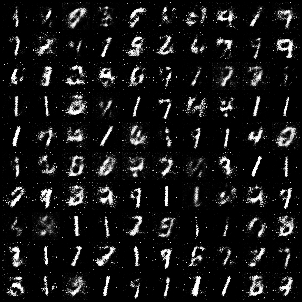

In [149]:
Image('./samples/fake_images-0050.png')

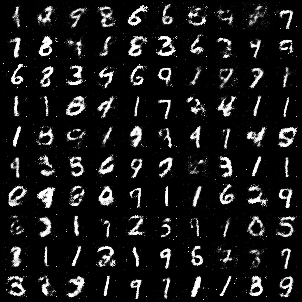

In [150]:
Image('./samples/fake_images-0100.png')

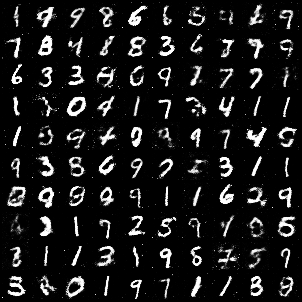

In [151]:
Image('./samples/fake_images-0150.png')

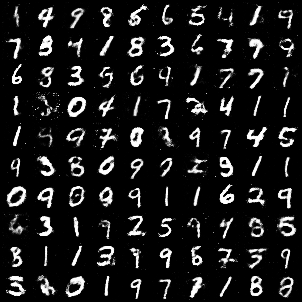

In [152]:
Image('./samples/fake_images-0200.png')

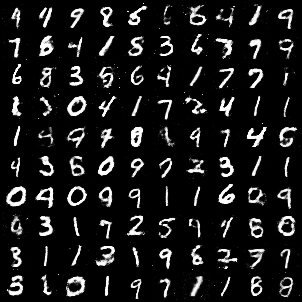

In [153]:
Image('./samples/fake_images-0300.png')